In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sb
import itertools
import warnings
import plotly.express as px
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn_pandas import DataFrameMapper
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
warnings.filterwarnings("ignore")

## Diccionario de datos
 
| Variable      |Definición                                                                | ¿Es utilizada? | Entrada/Salida |
|:--------------|:-------------------------------------------------------------------------|:--------------|:----------------|
|  id  |   Número correlativo de vuelos.                   | NO                              | -                             |
|  Airlines  | Nombre abreviado de la aerolinea.                | SI              | ENTRADA                                  |
|   Flight   | Número del vuelo.                            | NO              | -                                   |
|   AirportFrom   | De qué aeropuerto salió el vuelo.                         | Si                 | ENTRADA                         |
|    AirportTo  | A qué aeropuerto llegó el vuelo                 | SI           | ENTRADA                                        |
| DayOfWeek  | Día de la semana del vuelo.                 | SI           | ENTRADA                                                |         
| Time  | Hora de salida expresada en minutos.                  | SI           | ENTRADA                              |
| Length  | Duración del vuelo en minutos.                 | SI           | ENTRADA                              |
| Delay  | Si el vuelo esta demorado.                 | SI           | SALIDA                                      |

## Métricas

En nuestro caso contamos con el set de datos balanceado, por lo que vamos a utilizar como métrica Accuracy. Esta métrica es muy buena para la clacificación cuando el dataset está bien balanceado, evitando problemas como por ejemplo que prediga siempre la misma clase.

Esta métrica nos va a indicar el porcentaje de aciertos que tuvimos.

In [2]:
data=pd.read_csv('Airlines.csv')
data.head()

,id,Airline,Flight,AirportFrom,AirportTo,DayOfWeek,Time,Length,Delay
0,1,CO,269,SFO,IAH,3,15,205,1
1,2,US,1558,PHX,CLT,3,15,222,1
2,3,AA,2400,LAX,DFW,3,20,165,1
3,4,AA,2466,SFO,DFW,3,20,195,1
4,5,AS,108,ANC,SEA,3,30,202,0


In [3]:
data.describe()

,id,Flight,DayOfWeek,Time,Length,Delay
count,539383.000000,539383.000000,539383.000000,539383.000000,539383.000000,539383.000000
mean,269692.000000,2427.928630,3.929668,802.728963,132.202007,0.445442
std,155706.604461,2067.429837,1.914664,278.045911,70.117016,0.497015
min,1.000000,1.000000,1.000000,10.000000,0.000000,0.000000
25%,134846.500000,712.000000,2.000000,565.000000,81.000000,0.000000
50%,269692.000000,1809.000000,4.000000,795.000000,115.000000,0.000000
75%,404537.500000,3745.000000,5.000000,1035.000000,162.000000,1.000000
max,539383.000000,7814.000000,7.000000,1439.000000,655.000000,1.000000


## Limpieza y Pre Procesado:

Se eliminan las variables no utilizadas

In [4]:
df = data.drop(['id', 'Flight'],axis=1)
df.head()

,Airline,AirportFrom,AirportTo,DayOfWeek,Time,Length,Delay
0,CO,SFO,IAH,3,15,205,1
1,US,PHX,CLT,3,15,222,1
2,AA,LAX,DFW,3,20,165,1
3,AA,SFO,DFW,3,20,195,1
4,AS,ANC,SEA,3,30,202,0


Se eliminan datos atipicos

In [5]:
df= df.drop(df[(df['Length'] == 0)].index)

In [6]:
df.count()

Airline        539379
AirportFrom    539379
AirportTo      539379
DayOfWeek      539379
Time           539379
Length         539379
Delay          539379
dtype: int64

 ## Feature Engineering

In [7]:
## Funcion que calcula el momento del día
def momento_del_dia(hora):
    if hora >= 360 and hora < 720:
        return 'Mañana' ## MAÑANA
    elif hora >= 720 and hora < 1080:
        return 'Tarde' ## TARDE
    else:
        return 'Noche' ## NOCHE

In [8]:
df['MomentoDelDia'] = df['Time'].apply(momento_del_dia)

In [9]:
mapper = DataFrameMapper([
    (['Airline'], [OneHotEncoder()]),
    (['AirportFrom'], [OneHotEncoder()]),
    (['AirportTo'], [OneHotEncoder()]),
    (['DayOfWeek'], [StandardScaler()]),
    (['Time'], [StandardScaler()]),
    (['Length'], [StandardScaler()]),
    (['MomentoDelDia'], [OneHotEncoder()])
])

In [10]:
# Mapper sin dimensión MomentoDelDia
mapper2 = DataFrameMapper([
    (['Airline'], [OneHotEncoder()]),
    (['AirportFrom'], [OneHotEncoder()]),
    (['AirportTo'], [OneHotEncoder()]),
    (['DayOfWeek'], [StandardScaler()]),
    (['Time'], [StandardScaler()]),
    (['Length'], [StandardScaler()])
])

## Conjuntos de datos

In [11]:
# 60% train, 20% test, 20% validation
train, not_train = train_test_split(df, test_size=0.4, random_state=42)
validation, test = train_test_split(not_train, test_size=0.5, random_state=42)

train.shape, validation.shape, test.shape

((323627, 8), (107876, 8), (107876, 8))

### Función de evaluación

In [12]:
def evaluate_model(model, set_names=('train', 'validation'), title='', show_cm=False):
    if title:
        display(title)
        
    final_metrics = {
        'Accuracy': [],
    }
        
    for i, set_name in enumerate(set_names):
        assert set_name in ['train', 'validation', 'test']
        set_data = globals()[set_name]  # <- hack feo...

        y = set_data.Delay
        y_pred = model.predict(set_data)
        final_metrics['Accuracy'].append(metrics.accuracy_score(y, y_pred))
        
        if show_cm:
            cm = metrics.confusion_matrix(y, y_pred)
            cm_plot = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, 
                                                     display_labels=['No Delay', 'Delay'])
            cm_plot.plot(cmap="Blues")
        
    display(pd.DataFrame(final_metrics, index=set_names))

## Modelos
Utilizaremos los siguientes algoritmos:

- Regresión Logística
- Arboles de Decisión
- Random Forest
- Gradient Boosting

En este punto se entrenan y evalúan los modelos elegidos utilizando tanto parámetros estándar como algunos de los hiperparámetros principales de cada uno de ellos. 
Para finalizar tendremos nuestras conclusiones en base a las métricas y a su comportamiento.

## Primer modelo: Regresión logística sin variable MomentoDelDia

In [13]:
parameters = {'penalty': ['none', 'l2']}

clf = GridSearchCV(LogisticRegression(random_state=42, n_jobs=4), parameters, cv=5, scoring='accuracy')

gs_lr_model_1 = Pipeline([
    ('mapper', mapper2),
    ('classifier', clf),
])

gs_lr_model_1.fit(train, train.Delay)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

Pipeline(steps=[('mapper',
                 DataFrameMapper(drop_cols=[],
                                 features=[(['Airline'], [OneHotEncoder()]),
                                           (['AirportFrom'], [OneHotEncoder()]),
                                           (['AirportTo'], [OneHotEncoder()]),
                                           (['DayOfWeek'], [StandardScaler()]),
                                           (['Time'], [StandardScaler()]),
                                           (['Length'], [StandardScaler()])])),
                ('classifier',
                 GridSearchCV(cv=5,
                              estimator=LogisticRegression(n_jobs=4,
                                                           random_state=42),
                              param_grid={'penalty': ['none', 'l2']},
                              scoring='accuracy'))])

In [14]:
dimensiones = gs_lr_model_1.named_steps['classifier'].n_features_in_
print("Cantidad de dimensiones:", dimensiones)
print("Cross-Validation:", clf.best_score_)
print("Mejores Hiperparametros:", clf.best_params_)

Cantidad de dimensiones: 607
Cross-Validation: 0.6446742680829443
Mejores Hiperparametros: {'penalty': 'none'}


'Regresión Logistica'

,Accuracy
train,0.646463
validation,0.642441


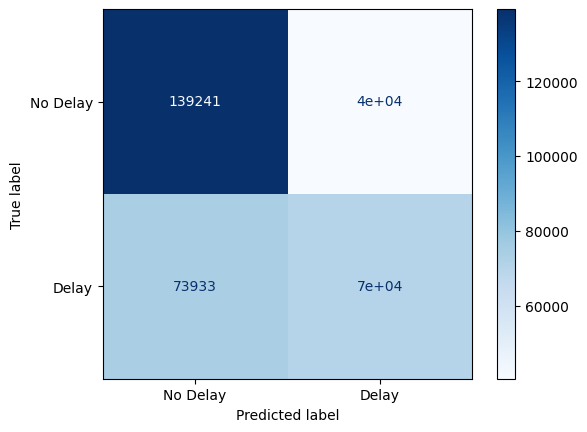

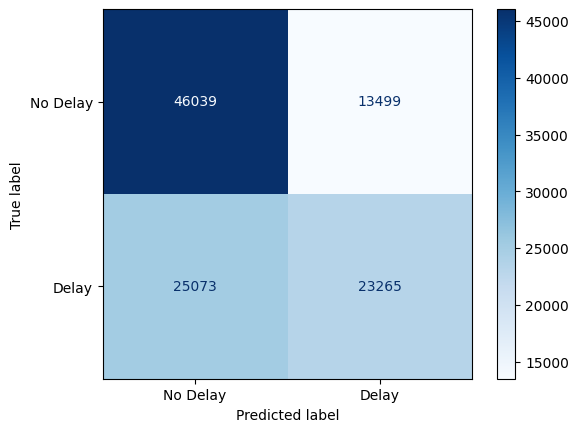

In [15]:
evaluate_model(gs_lr_model_1, title='Regresión Logistica', show_cm=True)

## Primer modelo: Regresión logística con variable MomentoDelDia

In [16]:
parameters = {'penalty': ['none', 'l2']}

clf = GridSearchCV(LogisticRegression(random_state=42, n_jobs=4), parameters, cv=5, scoring='accuracy')

gs_lr_model_2 = Pipeline([
    ('mapper', mapper),
    ('classifier', clf),
])

gs_lr_model_2.fit(train, train.Delay)

Pipeline(steps=[('mapper',
                 DataFrameMapper(drop_cols=[],
                                 features=[(['Airline'], [OneHotEncoder()]),
                                           (['AirportFrom'], [OneHotEncoder()]),
                                           (['AirportTo'], [OneHotEncoder()]),
                                           (['DayOfWeek'], [StandardScaler()]),
                                           (['Time'], [StandardScaler()]),
                                           (['Length'], [StandardScaler()]),
                                           (['MomentoDelDia'],
                                            [OneHotEncoder()])])),
                ('classifier',
                 GridSearchCV(cv=5,
                              estimator=LogisticRegression(n_jobs=4,
                                                           random_state=42),
                              param_grid={'penalty': ['none', 'l2']},
                              scoring='accuracy'))])

In [22]:
dimensiones = gs_lr_model_2.named_steps['classifier'].n_features_in_
print("Cantidad de dimensiones:", dimensiones)
print("Cross-Validation:", clf.best_score_)
print("Mejores Hiperparametros:", clf.best_params_)

Cantidad de dimensiones: 610
Cross-Validation: 0.6464170134444502
Mejores Hiperparametros: {'penalty': 'none'}


'Regresión Logistica'

,Accuracy
train,0.648021
validation,0.644073


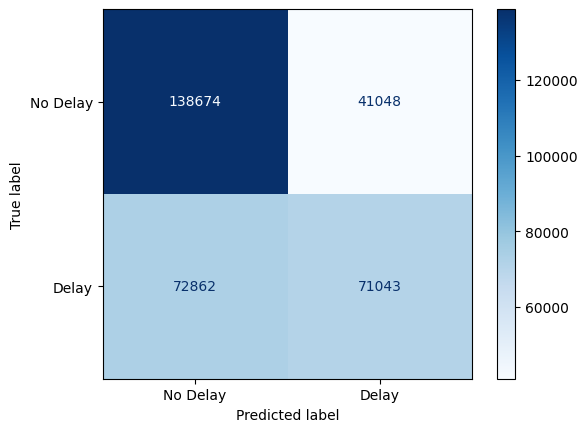

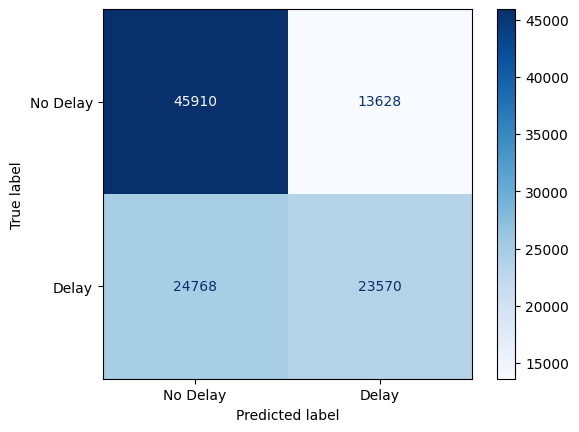

In [20]:
evaluate_model(gs_lr_model_2, title='Regresión Logistica', show_cm=True)

In [21]:
evaluate_model(gs_lr_model_1, title='Regresión Logistica sin Feature Engineering')
evaluate_model(gs_lr_model_2, title='Regresión Logistica con Feature Engineering')

'Regresión Logistica sin Feature Engineering'

,Accuracy
train,0.646463
validation,0.642441


'Regresión Logistica con Feature Engineering'

,Accuracy
train,0.648021
validation,0.644073


### Conclusión:
- Se evaluó el rendimiento del modelo Regresion Logistica con y sin la variable MomentoDeldia previamente creada. 
- Se visualiza una muy pequeña mejoría en las metricas del modelo que incluye la variable MomentoDelDia, con lo cual, concluimos que la creación de la nueva variable no es de mucha utilidad. 
- En adelante y proximos experimentos se continúa utilizando la variable creada para seguir evaluando su comportamiento.

Con este modelo el valor de accuracy es de 0.648021 sobre el conjunto de datos de train y 0.644073 sobre validation. Lo que significa que la probabilidad de que el modelo acierte sobre los vuelos demorados es de aproximadamente 64%.

### Reducción de dimensionalidad (PCA)

In [13]:
pca = PCA()

gs_pca = Pipeline([
    ('mapper', mapper),
    ('pca', pca), 
])

gs_pca.fit(train, train.Delay)

Pipeline(steps=[('mapper',
                 DataFrameMapper(drop_cols=[],
                                 features=[(['Airline'], [OneHotEncoder()]),
                                           (['AirportFrom'], [OneHotEncoder()]),
                                           (['AirportTo'], [OneHotEncoder()]),
                                           (['DayOfWeek'], [StandardScaler()]),
                                           (['Time'], [StandardScaler()]),
                                           (['Length'], [StandardScaler()]),
                                           (['MomentoDelDia'],
                                            [OneHotEncoder()])])),
                ('pca', PCA())])

In [14]:
# Definir qué fracción de la varianza se quiere mantener
var_frac = 0.95

# Calcular la suma acumulativa
cumsum = np.cumsum(pca.explained_variance_ratio_) 
# eso nos dice cuanta información es retenida si paramos en cada dimensión

# En qué momento la suma cumulativa llega a var_frac * 100 %?
d = np.argmax(cumsum >= var_frac) + 1
print('Con {} dimensiones, preservamos el {} de la varianza.'.format(d, var_frac))

Con 144 dimensiones, preservamos el 0.95 de la varianza.


Aplicamos la técnica PCA para reducir la dimensionalidad de nuestro conjunto de datos. Establecimos un 95% de varianza que queremos mantener y obtenemos la cantidad de dimensiones que necesitamos para alcanzar el porcetaje objetivo.

### Primer modelo: Regresión logística con PCA

In [25]:
parameters = {'penalty': ['none', 'l2']}

pca = PCA(n_components=d)

clf = GridSearchCV(LogisticRegression(random_state=42, n_jobs=4), parameters, cv=5, scoring='accuracy')

gs_lr_model_pca = Pipeline([
    ('mapper', mapper),
    ('pca', pca),
    ('classifier', clf),
    
])

gs_lr_model_pca.fit(train, train.Delay)

Pipeline(steps=[('mapper',
                 DataFrameMapper(drop_cols=[],
                                 features=[(['Airline'], [OneHotEncoder()]),
                                           (['AirportFrom'], [OneHotEncoder()]),
                                           (['AirportTo'], [OneHotEncoder()]),
                                           (['DayOfWeek'], [StandardScaler()]),
                                           (['Time'], [StandardScaler()]),
                                           (['Length'], [StandardScaler()]),
                                           (['MomentoDelDia'],
                                            [OneHotEncoder()])])),
                ('pca', PCA(n_components=144)),
                ('classifier',
                 GridSearchCV(cv=5,
                              estimator=LogisticRegression(n_jobs=4,
                                                           random_state=42),
                              param_grid={'penalty': ['none', 'l2']},
                              scoring='accuracy'))])

In [26]:
dimensiones = gs_lr_model_pca.named_steps['classifier'].n_features_in_
print("Cantidad de dimensiones:", dimensiones)
print("Cross-Validation Accuracy:", clf.best_score_)
print("Mejores Hiperparametros:", clf.best_params_)

Cantidad de dimensiones: 144
Cross-Validation Accuracy: 0.6436298519664084
Mejores Hiperparametros: {'penalty': 'none'}


'Regresión Logistica con PCA'

,Accuracy
train,0.643973
validation,0.640263


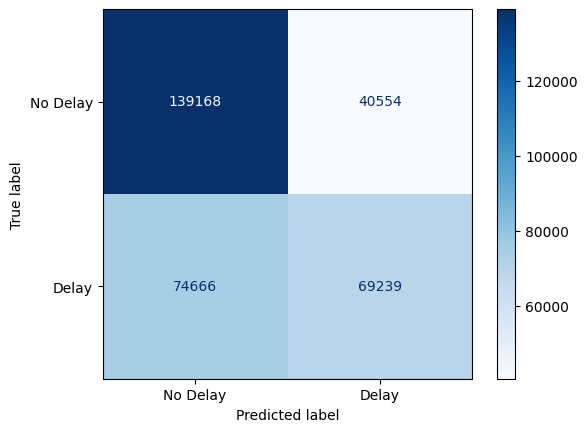

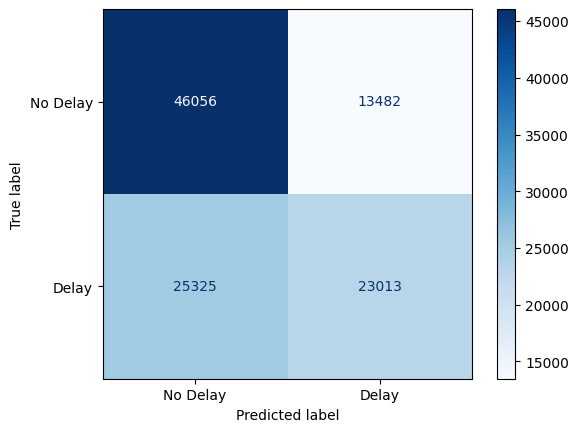

In [27]:
evaluate_model(gs_lr_model_pca, title='Regresión Logistica con PCA', show_cm=True)

### Conclusión:
- Se evaluó el rendimiento del modelo Regresion Logistica con PCA y Regresion Logistica con variable MomentoDelDia sin PCA previamente entrenado.
- Se visualiza que al aplicar PCA la metrica accuracy empeora en forma insignificante.
- Podemos concluir que aplicar PCA no mejora el rendimiento del modelo, sin embargo al reducirse la cantidad de dimensiones de 610 a 144 se observa una gran mejora en cuanto al tiempo de entrenamiento.

Con este modelo el valor de accuracy es de 0.643676 sobre el conjunto de datos de train y 0.640115 sobre validation. Lo que significa que la probabilidad de que el modelo acierte sobre los vuelos demorados es de aproximadamente 64%. 


## Segundo Modelo: Decision Tree


In [16]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelBinarizer

In [17]:
import graphviz  # pip install graphviz
from sklearn.tree import export_graphviz

def graph_tree(tree, col_names):
    graph_data = export_graphviz(
        tree, 
        out_file=None, 
        feature_names=col_names,  
        class_names=['delay', 'no_delay'],  
        filled=True, 
        rounded=True,  
        special_characters=True,
    )
    graph = graphviz.Source(graph_data)  
    return graph

**Decision Tree sin definir parametros**

In [18]:
tree_model = DecisionTreeClassifier(random_state=42)

dt_model = Pipeline([
    ('mapper', mapper),
    ('classifier', tree_model),
])

dt_model.fit(train, train.Delay)
evaluate_model(dt_model, title='Decision Tree')

print('Cantidad de nodos:', tree_model.tree_.node_count)
print('Profundidad máxima:', tree_model.tree_.max_depth)

'Decision Tree'

,Accuracy
train,0.848483
validation,0.606196


Cantidad de nodos: 226121
Profundidad máxima: 115


El resultado del entrenamiento sin definir parámetros es un overfitting en Train teniendo en cuenta la validacion. Sacando un 0.84% en train y en validacion un 0.60%, ademas llegando a una profundidad maxima de 115.

Esto se debe a que el arbol memoriza los ejemplos al no definirle una profundidad maxima.

**Decision Tree con max_depth**

In [31]:
# max_depth = 5
tree_model_max_deph = DecisionTreeClassifier(max_depth=5,random_state=42)
dt_model = Pipeline([
    ('mapper', mapper),
    ('classifier', tree_model_max_deph),
])

dt_model.fit(train, train.Delay)
evaluate_model(dt_model, title='Decision Tree - max_depth = 5')

print('Cantidad de nodos:', tree_model_max_deph.tree_.node_count)
print('Profundidad máxima:', tree_model_max_deph.tree_.max_depth)

'Decision Tree - max_depth = 5'

,Accuracy
train,0.638287
validation,0.636629


Cantidad de nodos: 63
Profundidad máxima: 5


Con un limite de 5 cambia totalmente los resultados,practicamente tiene los mismos resultados en train y validation.

Con un 0.638287% en train y 0.636629% en validation

Grafico de Decision Tree

In [32]:
graph_tree(tree_model_max_deph, mapper.transformed_names_ )

ExecutableNotFound: failed to execute PosixPath('dot'), make sure the Graphviz executables are on your systems' PATH

**Decision Tree con cross validation**

In [33]:
parameters={ 'max_depth':[5],'random_state':[42]}
tree_model_cv = GridSearchCV( DecisionTreeClassifier(),parameters, refit=True, verbose=1, cv=5)

dt_model = Pipeline([
    ('mapper', mapper),
    ('classifier', tree_model_cv),
])

dt_model.fit(train, train.Delay)
evaluate_model(dt_model, title='Decision Tree - max_depth - cross validation')

Fitting 5 folds for each of 1 candidates, totalling 5 fits


'Decision Tree - max_depth - cross validation'

,Accuracy
train,0.638287
validation,0.636629


No surgio ninguna diferencia realizando cross validation.

In [34]:
from collections import defaultdict
def overfitting_test(model, set_names=('train', 'validation')):
    final_metrics = defaultdict(list)
    for i, set_name in enumerate(set_names):
        assert set_name in ['train', 'validation', 'test']
        set_data = globals()[set_name]

        y = set_data.Delay
        y_pred = model.predict(set_data)
        final_metrics['Accuracy'].append(metrics.accuracy_score(y, y_pred))

    return final_metrics

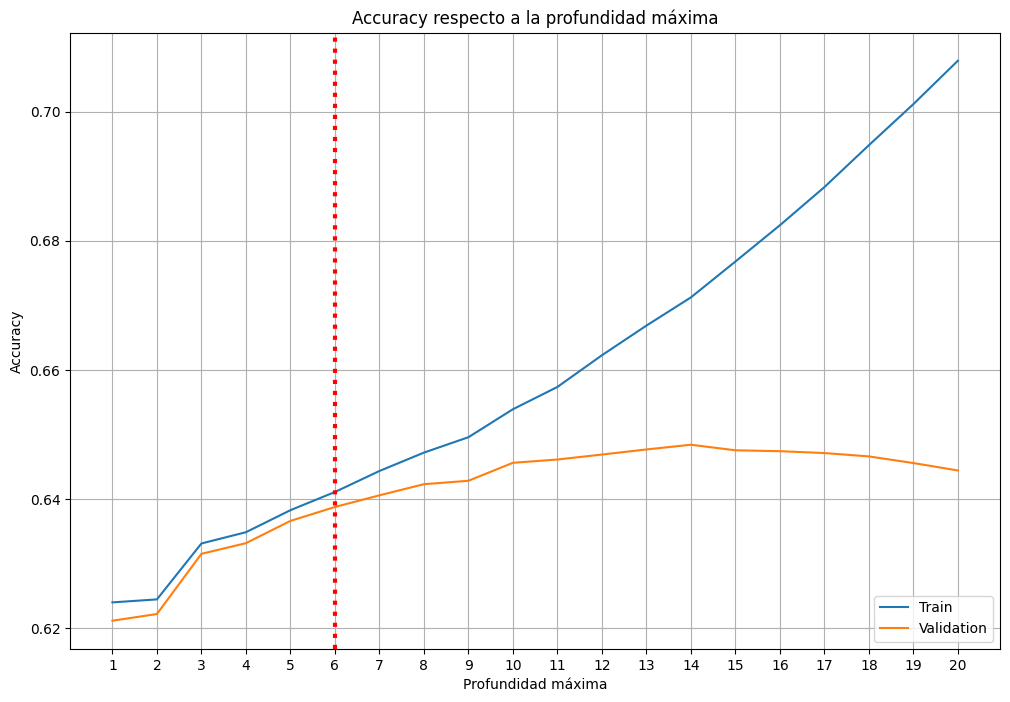

In [35]:
train_acc = []
validation_acc = []
for i in range(1,21):
    tree_model = DecisionTreeClassifier(max_depth=i, random_state=42)
    dt_model = Pipeline([
        ('mapper', mapper),
        ('classifier', tree_model),
    ])
    dt_model.fit(train, train.Delay)

    final_metrics = overfitting_test(dt_model)
    train_acc.append(final_metrics['Accuracy'][0])
    validation_acc.append(final_metrics['Accuracy'][1])

plt.figure(figsize=(12,8))
plt.plot(train_acc, label='Train')
plt.plot(validation_acc, label='Validation')
plt.axvline(x=5, linewidth=3, color='red', linestyle=':') 
plt.title('Accuracy respecto a la profundidad máxima')
plt.ylabel('Accuracy')
plt.xlabel('Profundidad máxima')
plt.xticks(np.arange(len(train_acc)), np.arange(1, len(train_acc)+1))
plt.legend(loc='lower right')
plt.grid()
plt.show()

Para el modelo final se realiza el corte a la profundidad máxima de 6, antes de que la divergencia entre los Accuracy de Train y Validation continúe acrecentándose.

## Tercer Modelo: Random Forest sin PCA

In [15]:
from sklearn.ensemble import RandomForestClassifier

In [37]:
parameters = {'n_estimators': [50], 
              'max_depth':[15,50],
              'criterion':['entropy','gini']}


clf = GridSearchCV(RandomForestClassifier(random_state=42, n_jobs=4), parameters, scoring='accuracy',refit=True, verbose=1)

gs_rf_model = Pipeline([
    ('mapper', mapper),
    ('classifier', clf),
])

gs_rf_model.fit(train, train.Delay)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


Pipeline(steps=[('mapper',
                 DataFrameMapper(drop_cols=[],
                                 features=[(['Airline'], [OneHotEncoder()]),
                                           (['AirportFrom'], [OneHotEncoder()]),
                                           (['AirportTo'], [OneHotEncoder()]),
                                           (['DayOfWeek'], [StandardScaler()]),
                                           (['Time'], [StandardScaler()]),
                                           (['Length'], [StandardScaler()]),
                                           (['MomentoDelDia'],
                                            [OneHotEncoder()])])),
                ('classifier',
                 GridSearchCV(estimator=RandomForestClassifier(n_jobs=4,
                                                               random_state=42),
                              param_grid={'criterion': ['entropy', 'gini'],
                                          'max_depth': [15, 50],
                                          'n_estimators': [50]},
                              scoring='accuracy', verbose=1))])

In [38]:
dimensiones = gs_rf_model.named_steps['classifier'].n_features_in_
print("Cantidad de dimensiones:", dimensiones)
print("Cross-Validation Accuracy:", clf.best_score_)
print("Mejores Hiperparametros:", clf.best_params_)

Cantidad de dimensiones: 610
Cross-Validation Accuracy: 0.6430767444719014
Mejores Hiperparametros: {'criterion': 'gini', 'max_depth': 15, 'n_estimators': 50}


'Random Forest sin PCA'

,Accuracy
train,0.649825
validation,0.639697


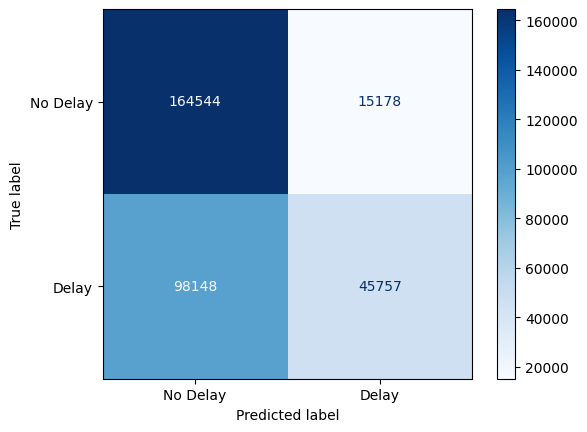

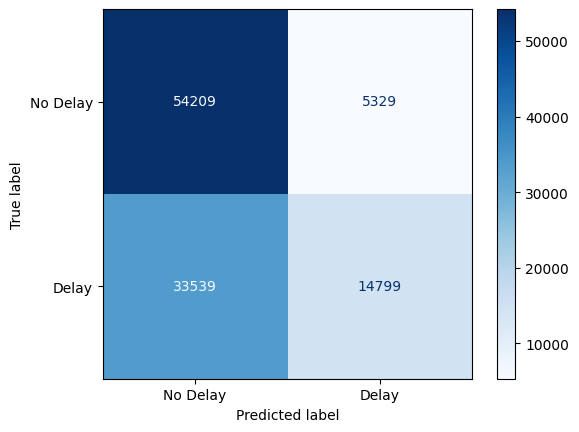

In [39]:
evaluate_model(gs_rf_model, title='Random Forest sin PCA', show_cm=True)

## Tercer Modelo: Random Forest con PCA

In [16]:
pca = PCA(n_components=d)

parameters = {'n_estimators': [50], 
              'max_depth':[15,50],
              'criterion':['entropy','gini']}

clf = GridSearchCV(RandomForestClassifier(random_state=42, n_jobs=4), parameters, scoring='accuracy', refit=True, verbose=1)

gs_rf_model_pca = Pipeline([
    ('mapper', mapper),
    ('pca', pca),
    ('classifier', clf),
])

gs_rf_model_pca.fit(train, train.Delay)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


Pipeline(steps=[('mapper',
                 DataFrameMapper(drop_cols=[],
                                 features=[(['Airline'], [OneHotEncoder()]),
                                           (['AirportFrom'], [OneHotEncoder()]),
                                           (['AirportTo'], [OneHotEncoder()]),
                                           (['DayOfWeek'], [StandardScaler()]),
                                           (['Time'], [StandardScaler()]),
                                           (['Length'], [StandardScaler()]),
                                           (['MomentoDelDia'],
                                            [OneHotEncoder()])])),
                ('pca', PCA(n_components=144)),
                ('classifier',
                 GridSearchCV(estimator=RandomForestClassifier(n_jobs=4,
                                                               random_state=42),
                              param_grid={'criterion': ['entropy', 'gini'],
                                          'max_depth': [15, 50],
                                          'n_estimators': [50]},
                              scoring='accuracy', verbose=1))])

In [41]:
dimensiones = gs_rf_model_pca.named_steps['classifier'].n_features_in_
print("Cantidad de dimensiones:", dimensiones)
print("Cross-Validation Accuracy:", clf.best_score_)
print("Mejores Hiperparametros:", clf.best_params_)

Cantidad de dimensiones: 144
Cross-Validation Accuracy: 0.66350458934914
Mejores Hiperparametros: {'criterion': 'entropy', 'max_depth': 15, 'n_estimators': 50}


'Random Forest con PCA'

,Accuracy
train,0.710213
validation,0.661927


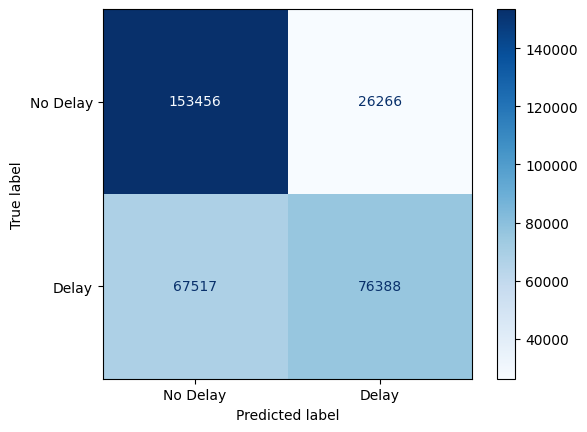

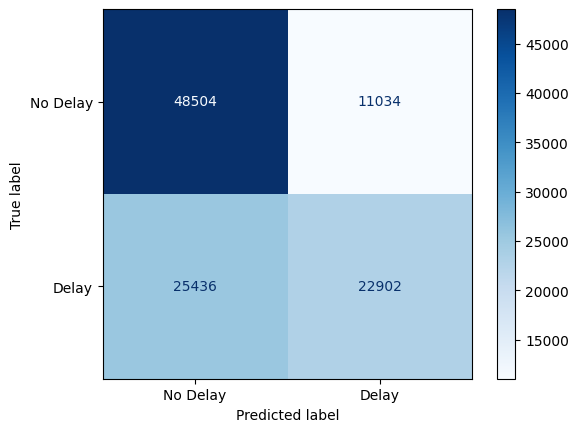

In [42]:
evaluate_model(gs_rf_model_pca, title='Random Forest con PCA', show_cm=True)

### Comparamos ambos

In [43]:
evaluate_model(gs_rf_model, title='Random Forest sin PCA')
evaluate_model(gs_rf_model_pca, title='Random Forest con PCA')

'Random Forest sin PCA'

,Accuracy
train,0.649825
validation,0.639697


'Random Forest con PCA'

,Accuracy
train,0.710213
validation,0.661927


### Conclusión:
- Se evaluó el rendimiento del modelo Random Forest con y sin PCA.
- Se visualiza que al aplicar PCA la métrica accuracy mejora un 6% en el conjunto train y un 2% en el conjunto validation.
- Podemos concluir entonces que aplicar PCA beneficia el modelo. Si bien PCA reduce la cantidad de dimensiones, la cantidad de informacion retenida es suficiente para identificar las caracteristicas mas importantes de los datos para lograr una mejor predicción y un mejor tiempo de entrenamiento.

Con este modelo Random Forest con PCA el valor de accuracy es de 0.710213 sobre el conjunto de datos de train y 0.661927 sobre validation.


## Cuarto modelo: Gradient Boosted Trees

In [20]:
from sklearn.ensemble import GradientBoostingClassifier

In [16]:
import graphviz
from sklearn.tree import export_graphviz

def graph_tree(tree):
    graph_data = export_graphviz(
        tree, 
        out_file=None, 
        feature_names=mapper.transformed_names_,  
        class_names=['Delay', 'No Delay'],  
        filled=True, 
        rounded=True,  
        special_characters=True,
    )
    graph = graphviz.Source(graph_data)  
    return graph

In [17]:
boost_model = Pipeline([
    ('mapper', mapper),
    ('classifier', GradientBoostingClassifier(random_state=42)),
])

In [47]:
boost_model.fit(train, train.Delay)

Pipeline(steps=[('mapper',
                 DataFrameMapper(drop_cols=[],
                                 features=[(['Airline'], [OneHotEncoder()]),
                                           (['AirportFrom'], [OneHotEncoder()]),
                                           (['AirportTo'], [OneHotEncoder()]),
                                           (['DayOfWeek'], [StandardScaler()]),
                                           (['Time'], [StandardScaler()]),
                                           (['Length'], [StandardScaler()]),
                                           (['MomentoDelDia'],
                                            [OneHotEncoder()])])),
                ('classifier', GradientBoostingClassifier(random_state=42))])

'Gradient Boosted Trees'

,Accuracy
train,0.649841
validation,0.646900


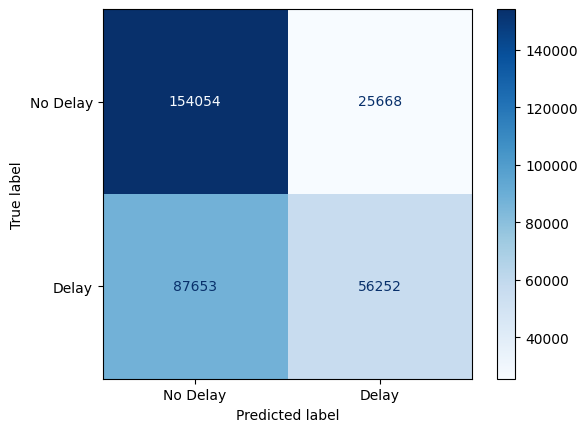

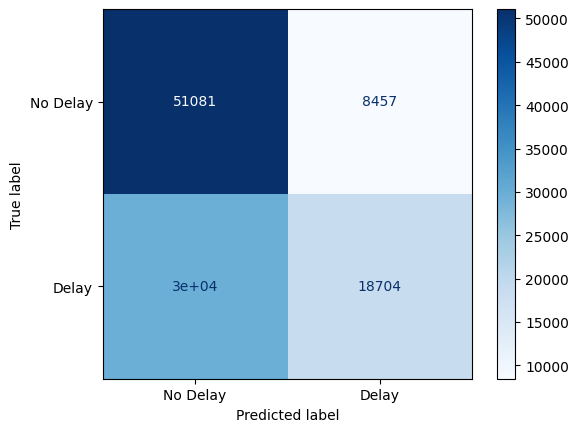

In [48]:
evaluate_model(boost_model, title='Gradient Boosted Trees', show_cm=True)

In [49]:
graph_tree(boost_model[1].estimators_[1][0])

ExecutableNotFound: failed to execute PosixPath('dot'), make sure the Graphviz executables are on your systems' PATH

### Gradient Boosting - Entrenamiento con parámetros estándar

In [50]:
# standard
gradient_model = GradientBoostingClassifier(random_state=42)
gb_model = Pipeline([
    ('mapper', mapper),
    ('classifier', gradient_model),
])

gb_model.fit(train, train.Delay)
evaluate_model(gb_model, title='Gradient Boosting')

'Gradient Boosting'

,Accuracy
train,0.649841
validation,0.646900


### Gradient Boosting - Cantidad de árboles
Entrenamiento definiendo un n_estimators de 4 (Default = 100). Este parámetro indica la cantidad de arboles que Gradient Boosting va a modelar.

In [51]:
# n_estimators = 4
gradient_model = GradientBoostingClassifier(n_estimators=4, random_state=42)
gb_model = Pipeline([
    ('mapper', mapper),
    ('classifier', gradient_model),
])

gb_model.fit(train, train.Delay)
evaluate_model(gb_model, title='Gradient Boosting - n_estimators = 4')

'Gradient Boosting - n_estimators = 4'

,Accuracy
train,0.624478
validation,0.622214


En este caso las métricas dan apenas uno o dos puntos porcentuales menos que la ejecución inicial sin parámetros. Esto parece indicar que el rendimiento del modelo llega a una meseta a partir de los 4 árboles creados.

#### Entrenamiento definiendo un n_estimators de 2 (Default = 100).

In [52]:
# n_estimators = 2
gradient_model = GradientBoostingClassifier(n_estimators=2, random_state=42)
gb_model = Pipeline([
    ('mapper', mapper),
    ('classifier', gradient_model),
])

gb_model.fit(train, train.Delay)
evaluate_model(gb_model, title='Gradient Boosting - n_estimators = 2')

'Gradient Boosting - n_estimators = 2'

,Accuracy
train,0.600642
validation,0.597149


En esta segunda prueba y con solo dos árboles creados, las métricas se mantienen muy similares al ejemplo anterior. Esto refuerza la teoría de que se forma una meseta a partir de, ahora, el segundo árbol utilizado.

#### Gradient Boosting - Learning rate
Entrenamiento con un learning_rate mucho mayor (20, en lugar del 0.1 por default).

In [53]:
# learning_rate = 20
gradient_model = GradientBoostingClassifier(learning_rate=20, random_state=42)
gb_model = Pipeline([
    ('mapper', mapper),
    ('classifier', gradient_model),
])

gb_model.fit(train, train.Delay)
evaluate_model(gb_model, title='Gradient Boosting - learning_rate = 20')

'Gradient Boosting - learning_rate = 20'

,Accuracy
train,0.372787
validation,0.375311


Esto resulta en una métrica Accuracy 30 puntos porcentuales más baja que la anterior, ya que el modelo falla y clasifica erroneamente a muchos de los casos. Por otro lado, el tiempo de ejecución se ve afectado solo mínimamente.

### Cuarto modelo: Gradient Boosted Trees con PCA

In [21]:
pca = PCA(n_components=d)

gradient_model_pca = Pipeline([
    ('mapper', mapper),
    ('pca', pca),
    ('classifier', GradientBoostingClassifier(random_state=42)),
])

gradient_model_pca.fit(train, train.Delay)

Pipeline(steps=[('mapper',
                 DataFrameMapper(drop_cols=[],
                                 features=[(['Airline'], [OneHotEncoder()]),
                                           (['AirportFrom'], [OneHotEncoder()]),
                                           (['AirportTo'], [OneHotEncoder()]),
                                           (['DayOfWeek'], [StandardScaler()]),
                                           (['Time'], [StandardScaler()]),
                                           (['Length'], [StandardScaler()]),
                                           (['MomentoDelDia'],
                                            [OneHotEncoder()])])),
                ('pca', PCA(n_components=144)),
                ('classifier', GradientBoostingClassifier(random_state=42))])

'Gradient Boosted Trees con PCA'

,Accuracy
train,0.656688
validation,0.651368


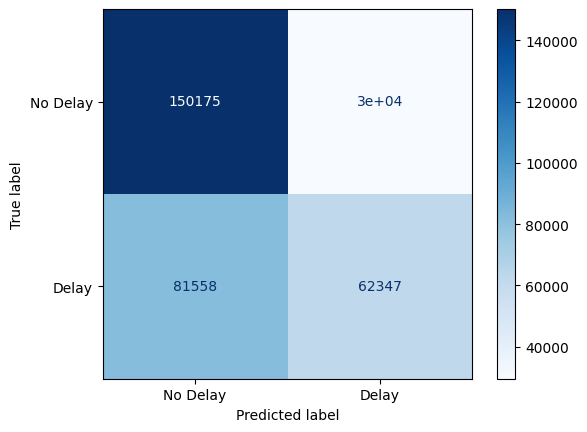

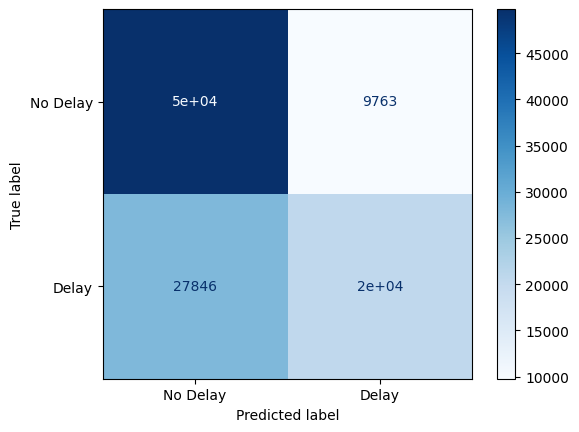

In [22]:
evaluate_model(gradient_model_pca, title='Gradient Boosted Trees con PCA', show_cm=True)

### Conclusión

Al aplicar PCA podemos notar que los resultados mejoran, sus resultados son mejores que en cualquiera de las variantes que probamos anteriormente.

## Tecnicas para evitar sobreentreniamiento

A lo largo de la experimentacion se utilizaron diferentes técnicas:
- Division de datos: se dividió el dataset en los conjuntos Train, Test y Validation. El conjunto de Train se lo utilizó para entrenar los modelos, el de Validation para validar las diferentes arquitecturas con las que se fueron experimentando y finalmente Test para valdiar el rendimiento del modelo final seleccionado.
- Cross Validation: el cual permite obtener estimaciones mas reales del rendimiento del modelo.
- Reduccion de dimensionalidad: al aplicar la técnica PCA nos permitió seleccionar solo las dimensiones mas relevantes, eliminando las menos relevantes y evitando asi la posibilidad de sobre entrenar.

## Selección del modelo

Teniendo en cuenta aspectos como interpretabilidad, tiempos de entrenamiento y metricas llegamos a la conclusión de que el modelo **Random Forest con la técnica de reduccion de dimensionalidad llamada PCA es el mejor**.

Este modelo logra buenos tiempos, los mejores resultados tanto en Train como en Validation y un valor aceptable en Test.

El modelo de Random Forest que hemos desarrollado muestra un accuracy del 66%, lo que significa que aproximadamente dos tercios de las predicciones realizadas por el modelo son correctas en términos de clasificar los vuelos como retrasados o no.

'Random Forest con PCA'

,Accuracy
train,0.710568
validation,0.661723
test,0.664847


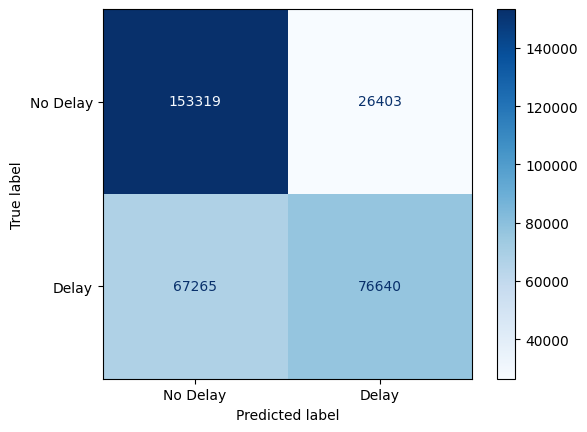

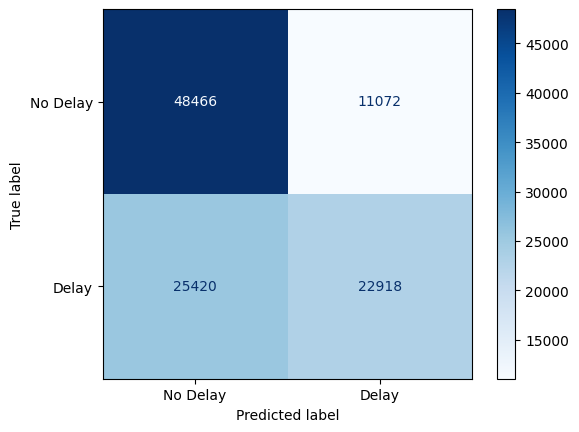

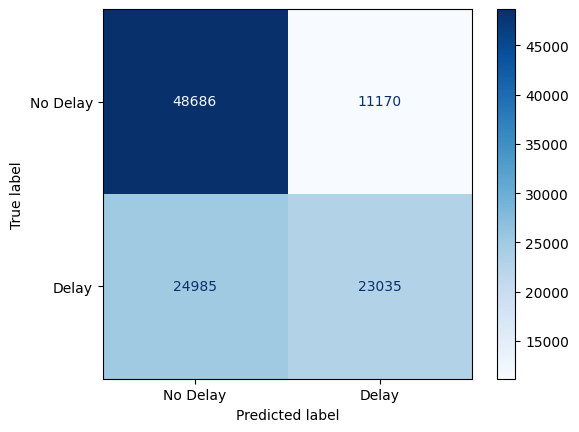

In [20]:
evaluate_model(gs_rf_model_pca, title='Random Forest con PCA', set_names=('train', 'validation', 'test'), show_cm=True)

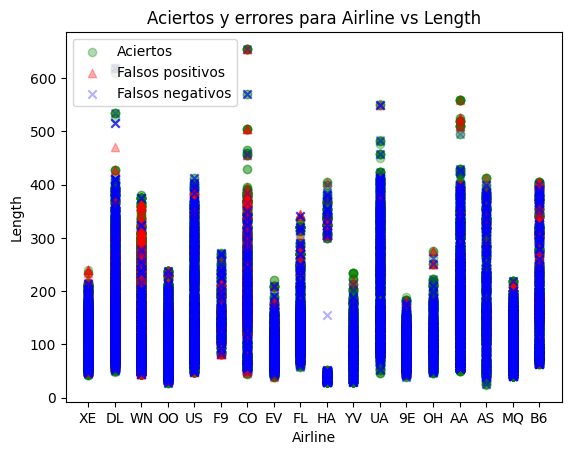

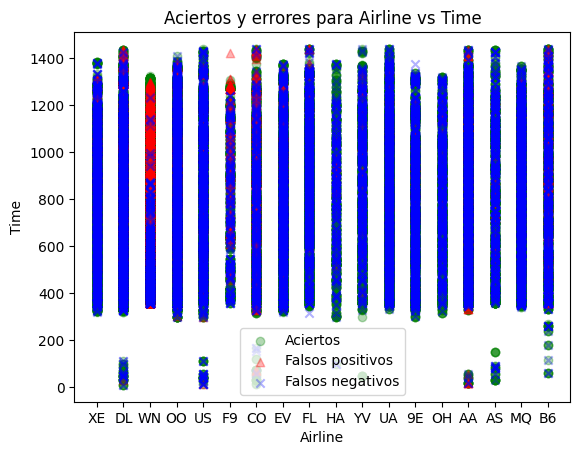

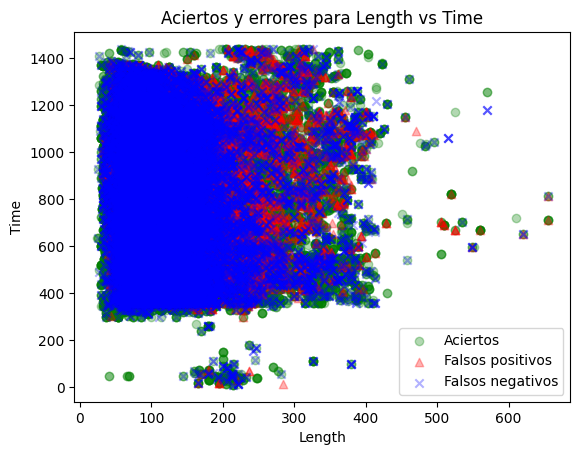

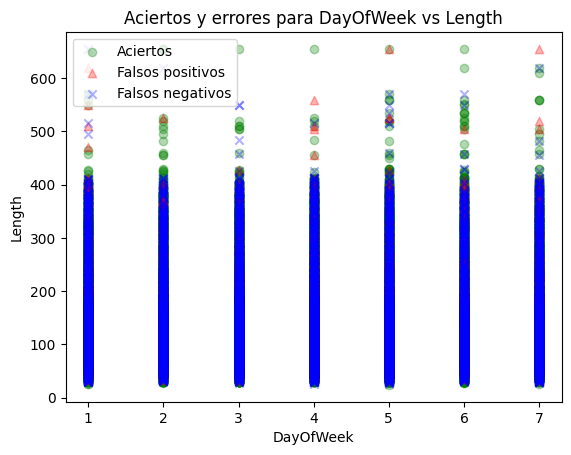

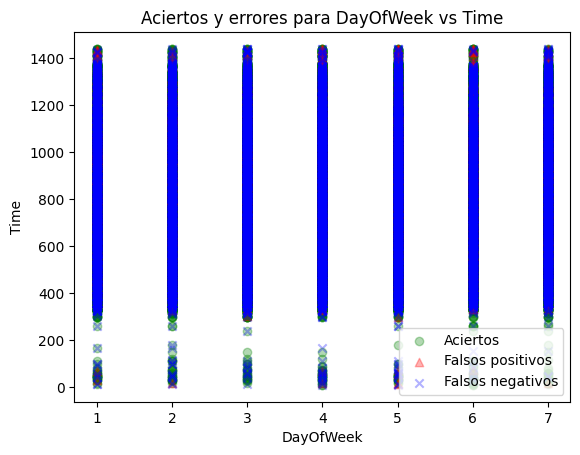

In [17]:
predicciones = gs_rf_model_pca.predict(test)
predicciones_correctas = predicciones == test.Delay
falso_positivo = (predicciones == 1) & (test.Delay == 0)
falso_negativo = (predicciones == 0) & (test.Delay == 1)

results = pd.DataFrame({'Prediction': predicciones, 'Actual': test.Delay})

variables = [('Airline', 'Length'), ('Airline', 'Time'), ('Length', 'Time'), ('DayOfWeek', 'Length'),('DayOfWeek', 'Time')]


for pair in variables:
    var1, var2 = pair
    plt.figure()
    plt.scatter(test[var1][predicciones_correctas], test[var2][predicciones_correctas], marker='o', c='green', label='Aciertos', alpha=0.3)
    plt.scatter(test[var1][falso_positivo], test[var2][falso_positivo], marker='^', c='red', label='Falsos positivos', alpha=0.3)
    plt.scatter(test[var1][falso_negativo], test[var2][falso_negativo], marker='x', c='blue', label='Falsos negativos', alpha=0.3)
    plt.xlabel(var1)
    plt.ylabel(var2)
    plt.title('Aciertos y errores para {} vs {}'.format(var1, var2))
    plt.legend()
    plt.show()

### Conclusión
Luego de graficar los aciertos, falsos positivos y negativos en diferentes pares de variables, se visualiza una superposicion importante entre las diferentes clases. Con lo cual concluimos que los diferentes pares de variables seleccionadas no son lo suficientemente informativas para establecer limites claros que permitan diferenciar porque en ciertos casos el modelo predice mal.


### Importancia de Variables

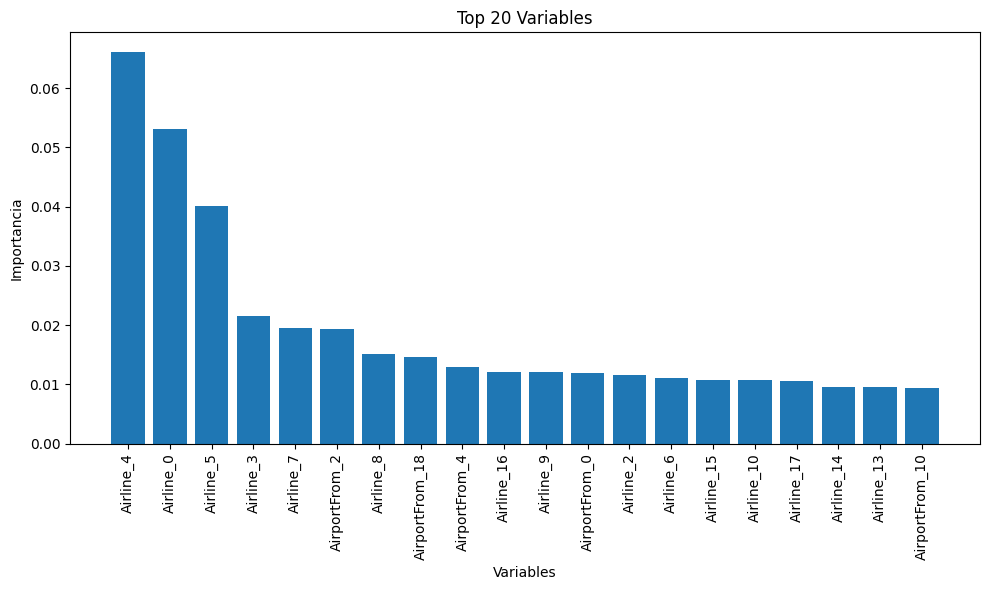

In [23]:
importancia = gs_rf_model_pca.named_steps['classifier'].best_estimator_.feature_importances_

feature_names = gs_rf_model_pca.named_steps['mapper'].transformed_names_

indices = np.argsort(importancia)[::-1]

sorted_feature_names = [feature_names[i] for i in indices[:20]]  # Mostrar solo las 20 más importantes

sorted_impor = importancia[indices[:20]]

plt.figure(figsize=(10, 6))
plt.bar(range(len(sorted_impor)), sorted_impor)
plt.xticks(range(len(sorted_impor)), sorted_feature_names, rotation='vertical')
plt.xlabel('Variables')
plt.ylabel('Importancia')
plt.title('Top 20 Variables')

plt.tight_layout()
plt.show()

Al analizar el conjunto de datos y aplicarle la tecnica Random Forest, identificamos que las variables mas importantes identificadas por el modelo para predecir estan relacionadas a la variable Airlines.